In [5]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression

#### Study procedure
- 3 conditions for radius and distance
- 3 trails per condition
- 7 clicks per trial (= click every target once)
- 4 devices
  - every participant did every device
- logged that data of every paricipant-device combo
  - raw data in `logs`-folder
- experiments were done on the same laptop
  - exception 0-pose, because of time constraints

#### Visualizing Results

In [6]:
# get data 

mouse_files = glob.glob('../logs/*mouse*.csv')
latency_files = glob.glob('../logs/*latency*.csv')
touchpad_files = glob.glob('../logs/*touchpad*.csv')
pose_files = glob.glob('../logs/*pose*.csv')

def create_dataframe(files):
    df = None
    for file in files:
        tmp_df = pd.read_csv(file)
        if df is None:
            df = tmp_df.copy()
        else:
            df = pd.concat([df, tmp_df], ignore_index=True)
    
    df.drop(df.columns[0], axis=1, inplace=True)
    return df

df_mouse = create_dataframe(mouse_files)
df_latency = create_dataframe(latency_files)
df_touchpad = create_dataframe(touchpad_files)
df_pose = create_dataframe(pose_files)

df_mouse

,id,trial,radius,distance,latency,hit,time,accuracy,click_x,click_y,target_x,target_y,click_time
0,0,0,25,110,0,True,2.416889,7.810250,466,355,460.000000,350.000000,1.719503e+09
1,0,0,25,110,0,True,1.214197,8.962157,244,308,250.893425,302.272789,1.719503e+09
2,0,0,25,110,0,True,0.822047,4.020131,419,440,418.583878,436.001463,1.719503e+09
3,0,0,25,110,0,True,0.569839,5.268065,325,248,325.522697,242.757930,1.719503e+09
4,0,0,25,110,0,True,0.949701,18.028868,308,453,325.522697,457.242070,1.719503e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,2,2,50,180,0,True,0.816883,25.759210,288,188,309.946232,174.512976,1.719593e+09
185,2,2,50,180,0,True,0.751928,7.208806,317,524,309.946232,525.487024,1.719593e+09
186,2,2,50,180,0,True,0.708034,11.337054,461,198,462.228164,209.270333,1.719593e+09
187,2,2,50,180,0,True,0.730992,32.629257,206,401,187.825604,428.099073,1.719593e+09


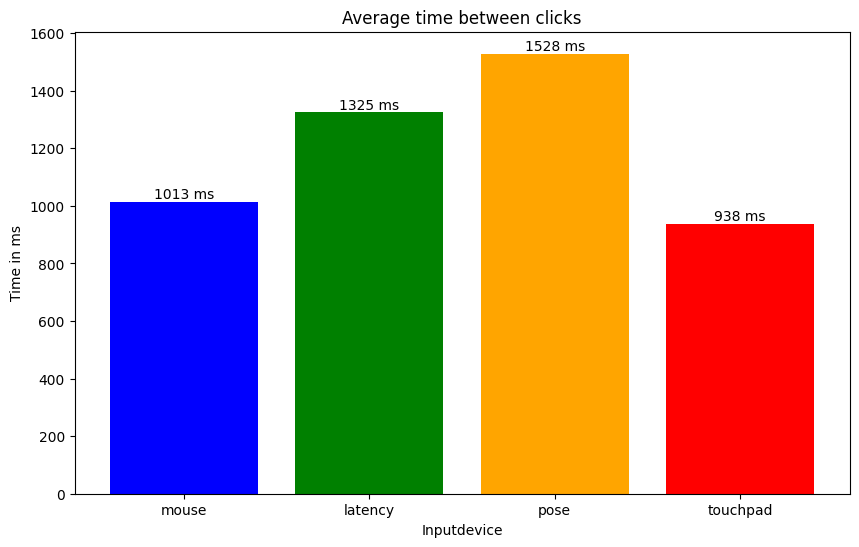

In [7]:
def calculate_average_movement_time(df):
    # s to ms
    df['time_ms'] = df['time'] * 1000
    return df['time_ms'].mean()


def calculate_average_movement_time_seconds(df):
    df['time_ms'] = df['time']
    return df['time_ms'].mean()


avg_speed_ms = {
    'mouse': calculate_average_movement_time(df_mouse),
    'latency': calculate_average_movement_time(df_latency),
    'pose': calculate_average_movement_time(df_pose),
    'touchpad': calculate_average_movement_time(df_touchpad)
}

avg_speed_s = {
    'mouse': calculate_average_movement_time_seconds(df_mouse),
    'latency': calculate_average_movement_time_seconds(df_latency),
    'pose': calculate_average_movement_time_seconds(df_pose),
    'touchpad': calculate_average_movement_time_seconds(df_touchpad)
}

plt.figure(figsize=(10, 6))
# ---------------------

dfs = list(avg_speed_ms.keys())
times = list(avg_speed_ms.values())

plt.bar(dfs, times, color=['blue', 'green', 'orange', 'red'])
plt.xlabel('Inputdevice')
plt.ylabel('Time in ms')
plt.title('Average time between clicks')

for key, time in enumerate(times):
    plt.text(key, time + 0.2, f'{int(time)} ms', ha='center', va='bottom', fontsize=10)

plt.show()

- Time between clicks is longest for pose-detection
- and very similar for mouse and touchpad

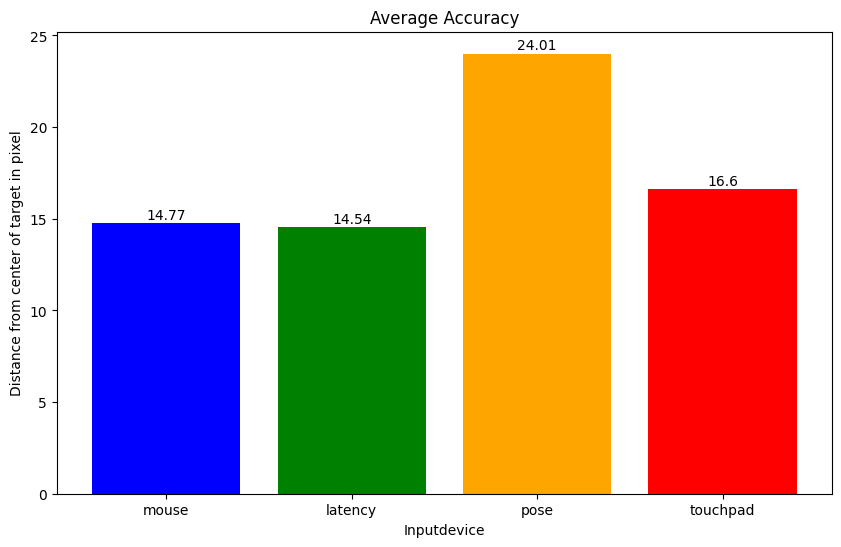

In [18]:
def calculate_average_accuracy(df):
    return df['accuracy'].mean()

avg_accuracy = {
    'mouse': calculate_average_accuracy(df_mouse),
    'latency': calculate_average_accuracy(df_latency),
    'pose': calculate_average_accuracy(df_pose),
    'touchpad': calculate_average_accuracy(df_touchpad)
}

plt.figure(figsize=(10, 6))

dfs = list(avg_accuracy.keys())
accuracies = list(avg_accuracy.values())

plt.bar(dfs, accuracies, color=['blue', 'green', 'orange', 'red'])
plt.xlabel('Inputdevice')
plt.ylabel('Distance from center of target in pixel')
plt.title('Average Accuracy')

for key, accuracy in enumerate(accuracies):
    plt.text(key, accuracy + 0.05, f'{round(accuracy, 2)}', ha='center', va='bottom', fontsize=10)

# the smaller the number the better the accuracy
plt.show()


Intercept (a) of Regression mouse: -1.897190303951505
Coefficient (b) of Regression mouse: 0.9483670068804405
Intercept (a) of Regression latency: -1.6698831072870945
Coefficient (b) of Regression latency: 0.97603682023338
Intercept (a) of Regression pose: -1.251581112394778
Coefficient (b) of Regression pose: 0.9057802594924697
Intercept (a) of Regression touchpad: -0.5445205210529067
Coefficient (b) of Regression touchpad: 0.4832490179629717


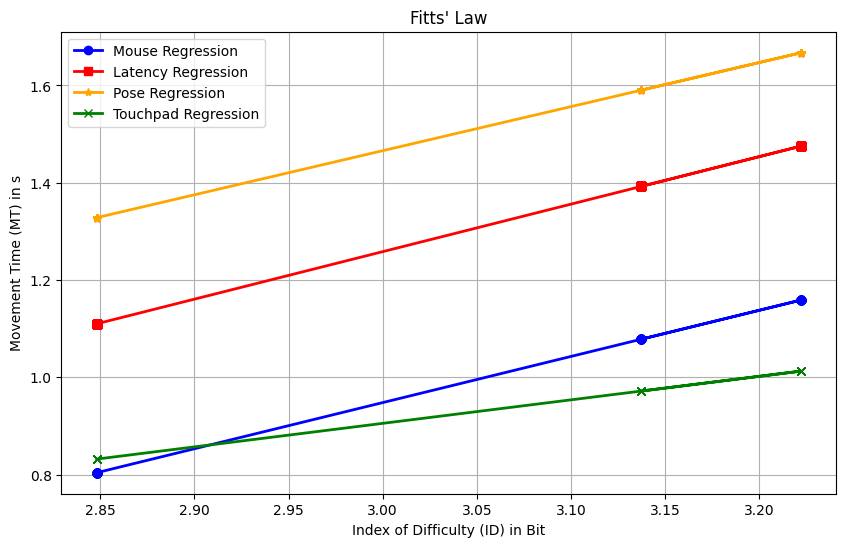

In [302]:
#  Index of difficulty Fits Law:
#  D = distance = 2 * distance to center
#  W = width = 2 * radius 
def calculate_ID(df):
    return np.log2(2 * (df['distance'] * 2 ) / (df['radius'] * 2))

def calculate_MT(df, name):
    x = df['ID'].values.reshape(-1, 1)
    y = df['time'].values.reshape(-1, 1)
    regression = LinearRegression().fit(x, y)
    print(f"Intercept (a) of Regression {name}: {regression.intercept_[0]}")
    print(f"Coefficient (b) of Regression {name}: {regression.coef_[0][0]}")
    return regression
    
df_mouse['ID'] = calculate_ID(df_mouse)
df_latency['ID'] = calculate_ID(df_latency)
df_pose['ID'] = calculate_ID(df_pose)
df_touchpad['ID'] = calculate_ID(df_touchpad)

MT_mouse = calculate_MT(df_mouse, 'mouse')
MT_latency = calculate_MT(df_latency, 'latency')
MT_pose = calculate_MT(df_pose, 'pose')
MT_touchpad = calculate_MT(df_touchpad, 'touchpad')

X_mouse = df_mouse['ID'].values.reshape(-1, 1)
y_mouse = df_mouse['time'].values.reshape(-1, 1)

X_latency = df_latency['ID'].values.reshape(-1, 1)
y_latency = df_latency['time'].values.reshape(-1, 1)

X_pose = df_pose['ID'].values.reshape(-1, 1)
y_pose = df_pose['time'].values.reshape(-1, 1)

X_touchpad = df_touchpad['ID'].values.reshape(-1, 1)
y_touchpad = df_touchpad['time'].values.reshape(-1, 1)

plt.figure(figsize=(10, 6))

# scatter plots for dfs (uncomment if you want to see!)
# plt.scatter(df_mouse['ID'], df_mouse['time'], marker='x', color='red', label='Mouse')
# plt.scatter(df_latency['ID'], df_latency['time'], marker='o', color='blue', label='Latency')
# plt.scatter(df_pose['ID'], df_pose['time'], marker='^', color='green', label='Pose')
# plt.scatter(df_touchpad['ID'], df_touchpad['time'], marker='s', color='orange', label='Touchpad')


plt.plot(X_mouse, MT_mouse.predict(X_mouse), color='blue', linewidth=2, label='Mouse Regression', marker="o")
plt.plot(X_latency, MT_latency.predict(X_latency), color='red', linewidth=2, label='Latency Regression', marker="s")
plt.plot(X_pose, MT_pose.predict(X_pose), color='orange', linewidth=2, label='Pose Regression', marker="*")
plt.plot(X_touchpad, MT_touchpad.predict(X_touchpad), color='green', linewidth=2, label='Touchpad Regression', marker="x")

plt.xlabel('Index of Difficulty (ID) in Bit')
plt.ylabel('Movement Time (MT) in s')
plt.title("Fitts' Law")
plt.grid(True)
plt.legend()
plt.show()

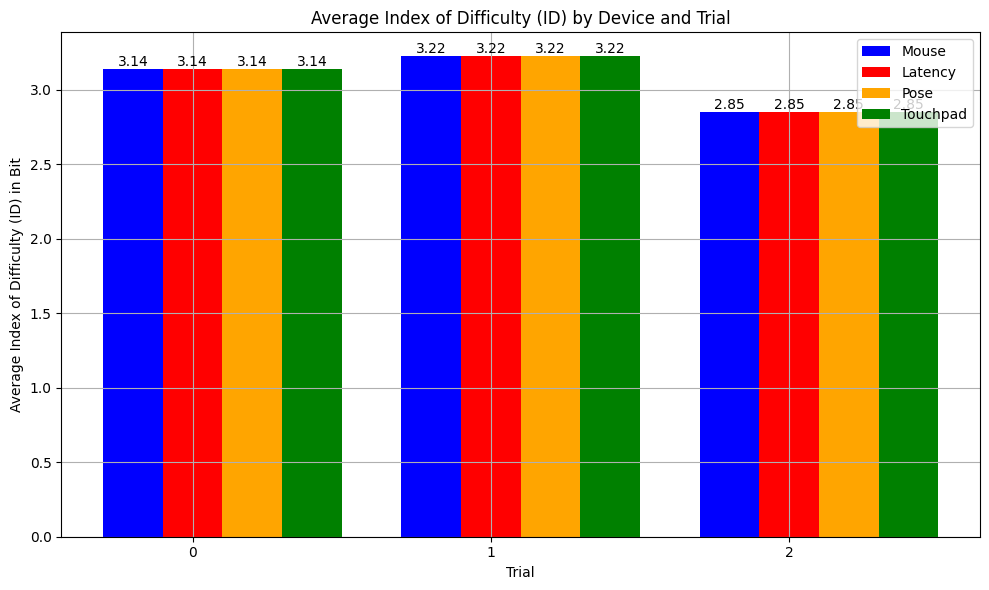

In [303]:

trials = df_mouse['trial'].unique()
dfs = {
    'Mouse': df_mouse,
    'Latency': df_latency,
    'Pose': df_pose,
    'Touchpad': df_touchpad
}

avg_ids = {device: [] for device in dfs.keys()}

# calculate average ID for each trial and device
for trial in trials:
    for device, df in dfs.items():
        avg_id = df[df['trial'] == trial]['ID'].mean()
        avg_ids[device].append(avg_id)

plt.figure(figsize=(10, 6))
bar_width = 0.1
index = np.arange(len(trials)) * (len(dfs) + 1) * bar_width  # adding extra space between groups


colors = ['blue', 'red', 'orange', 'green']

for i, (device, avg_values) in enumerate(avg_ids.items()):
    bar_positions = [x + i * bar_width for x in index]
    bars = plt.bar(bar_positions, avg_values, bar_width, label=device, color=colors[i])
    for bar, avg_value in zip(bars, avg_values):
        plt.text(bar.get_x() + bar.get_width() / 2.0, bar.get_height(), f'{avg_value:.2f}', ha='center', va='bottom')


plt.xlabel('Trial')
plt.ylabel('Average Index of Difficulty (ID) in Bit')
plt.title('Average Index of Difficulty (ID) by Device and Trial')
plt.xticks([r + bar_width for r in index], trials)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

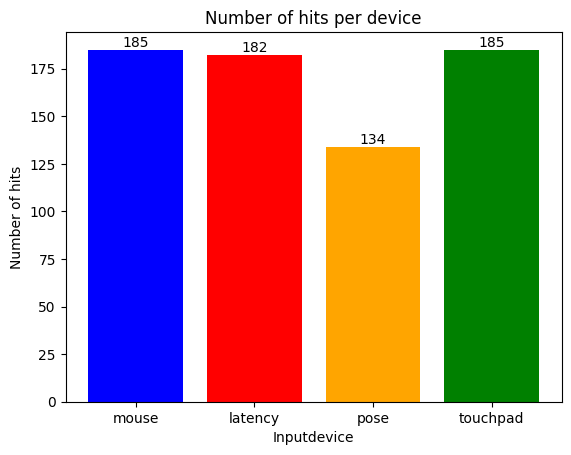

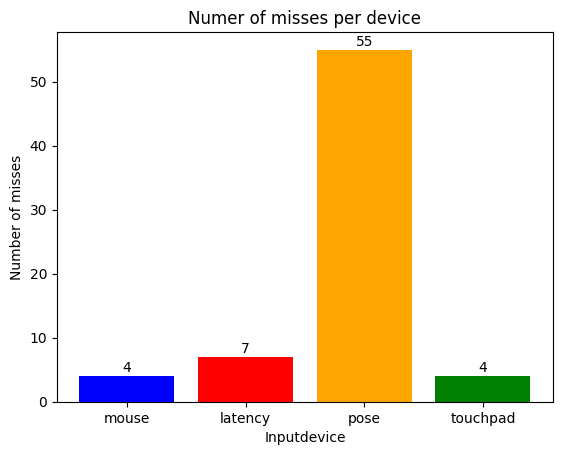

In [16]:
hit_counts = {
    'mouse': df_mouse[df_mouse['hit'] == True].shape[0],
    'latency': df_latency[df_latency['hit'] == True].shape[0],
    'pose': df_pose[df_pose['hit'] == True].shape[0],
    'touchpad': df_touchpad[df_touchpad['hit'] == True].shape[0]
}

miss_counts = {
    'mouse': df_mouse[df_mouse['hit'] == False].shape[0],
    'latency': df_latency[df_latency['hit'] == False].shape[0],
    'pose': df_pose[df_pose['hit'] == False].shape[0],
    'touchpad': df_touchpad[df_touchpad['hit'] == False].shape[0]
}

dfs = list(hit_counts.keys())
hits = list(hit_counts.values())

plt.bar(dfs, hits, color=['blue', 'red', 'orange', 'green'])
plt.xlabel('Inputdevice')
plt.ylabel('Number of hits')
plt.title('Number of hits per device')

for i, v in enumerate(hits):
    plt.text(i, v + 0.2, str(v), ha='center', va='bottom', fontsize=10)

plt.show()

# Erstellung des Bar-Charts für Fehler
dfs = list(miss_counts.keys())
miss = list(miss_counts.values())

plt.bar(dfs, miss, color=['blue', 'red', 'orange', 'green'])
plt.xlabel('Inputdevice')
plt.ylabel('Number of misses')
plt.title('Numer of misses per device')

# Text über den Balken hinzufügen
for i, v in enumerate(miss):
    plt.text(i, v + 0.2, str(v), ha='center', va='bottom', fontsize=10)

plt.show()


## All hits of all trials

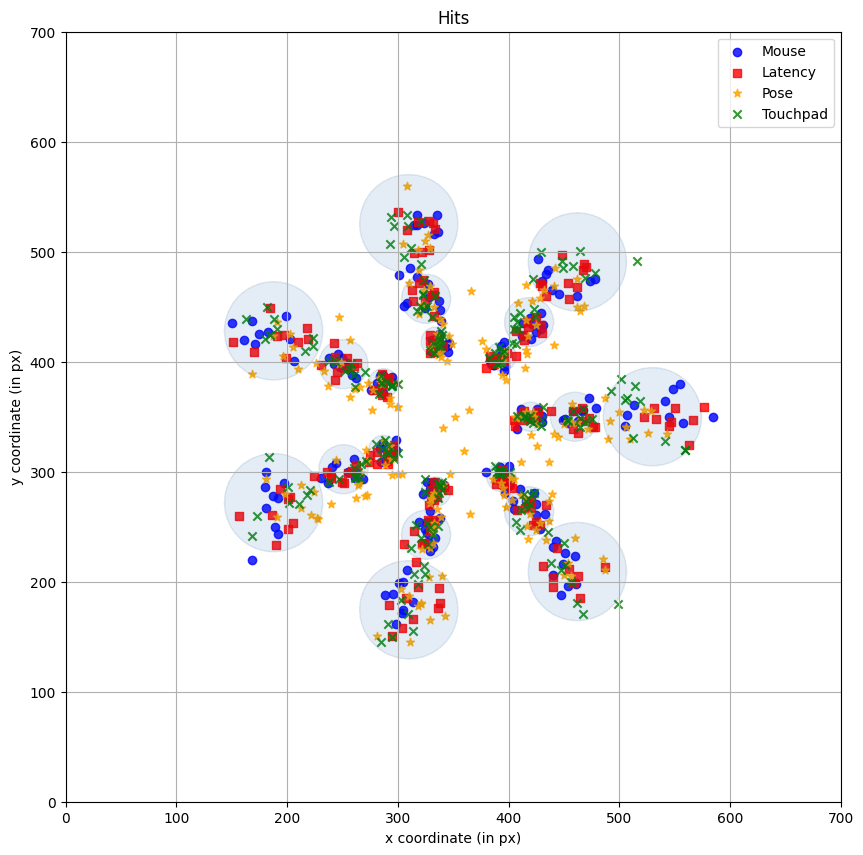

In [304]:
fig = plt.figure(figsize=(10, 10))

plt.scatter(df_mouse['click_x'], df_mouse['click_y'], marker='o', color='blue', label='Mouse', alpha=0.8)
plt.scatter(df_latency['click_x'], df_latency['click_y'], marker='s', color='red', label='Latency', alpha=0.8)
plt.scatter(df_pose['click_x'], df_pose['click_y'], marker='*', color='orange', label='Pose', alpha=0.8)
plt.scatter(df_touchpad['click_x'], df_touchpad['click_y'], marker='x', color='green', label='Touchpad', alpha=0.8)

plt.scatter(df_mouse['target_x'], df_mouse['target_y'], s=df_mouse['radius']**2*2 , alpha=0.01)
# s=points^2 -> https://stackoverflow.com/a/36753295


plt.xlim(0, 700)
plt.ylim(0, 700)
plt.xlabel('x coordinate (in px)')
plt.ylabel('y coordinate (in px)')
plt.title("Hits")
plt.grid(True)
plt.legend()
plt.show()

## Plot trial paths

In [374]:
WINDOW_SIZE = 700
CMAP = 'Set2'

In [395]:
def get_id_dfs(df):
    ids = df['id'].unique()
    id_dfs = {int(id_value): df[df['id'] == id_value] for id_value in ids}
    return id_dfs

def get_trials_from_ids(ids):
    res = {}
    for key, value in ids.items():
        trials = value['trial'].unique()
        trials = {int(trial): value[value['trial'] == trial] for trial in trials}
        res[key] = trials
    
    return res

def plot_trial_path(df):
    # plt.figure(figsize=(6, 6))

    radius = df['radius'].iloc[0]
    distance = df['distance'].iloc[0]
    trial = df['trial'].iloc[0]
    
    # Plotten der Pfade
    # cmap = plt.cm.get_cmap(CMAP)
    # c = cmap(trial)
    plt.plot(df['click_x'], df['click_y'], marker="o", linestyle='--', alpha=0.5)
    
    # Zeiten entlang der Pfade schreiben
    for i in range(len(df)-1):
        x1, y1 = df.iloc[i]['click_x'], df.iloc[i]['click_y']
        x2, y2 = df.iloc[i+1]['click_x'], df.iloc[i+1]['click_y']
        time = df.iloc[i+1]['time']
        # plt.text((x1 + x2) / 2, (y1 + y2) / 2, f'{time:.2f} s', fontsize=9, ha='right')
    
    # radius = df['radius'].iloc[0]
    # trial = df['trial'].iloc[0]

    # plt.scatter(df['target_x'], df['target_y'], s=radius**2 , alpha=0.05)

    plt.xlim(0, WINDOW_SIZE)
    plt.ylim(0, WINDOW_SIZE)

    plt.title(f'Trial {trial}  - Radius {radius} - Distance {distance}')
    plt.xlabel('click_x')
    plt.ylabel('click_y')
    plt.grid(True)
    # plt.show()


mouse_ids = get_id_dfs(df_mouse)
latency_ids = get_id_dfs(df_latency)
touchpad_ids = get_id_dfs(df_touchpad)
pose_ids = get_id_dfs(df_pose)

mouse_trials = get_trials_from_ids(mouse_ids)
latency_trials = get_trials_from_ids(latency_ids)
touchpad_trials = get_trials_from_ids(touchpad_ids)
pose_trials = get_trials_from_ids(pose_ids)


In [402]:
colors = ["tab:pink", "tab:cyan", "tab:purple"]
def plot_all_hits(df):
    # fig, ax = plt.subplots(dpi=100)
    plt.scatter(df['click_x'], df['click_y'], alpha=0.5, c=df["trial"], cmap=CMAP)
    # df.plot(x="click_x", y="click_y", kind="scatter", xlim=(0, WINDOW_SIZE), ylim=(0, WINDOW_SIZE), ax=plt.gca(), hue="trial")

    # plt.scatter(df['target_x'], df['target_y'] , alpha=0.01)
    # s=points^2 -> https://stackoverflow.com/a/36753295 -> different size, because of subplots

    plt.xlim(0, WINDOW_SIZE)
    plt.ylim(0, WINDOW_SIZE)
    plt.xlabel('x coordinate (in px)')
    plt.ylabel('y coordinate (in px)')
    plt.title("Hits")
    plt.grid(True)


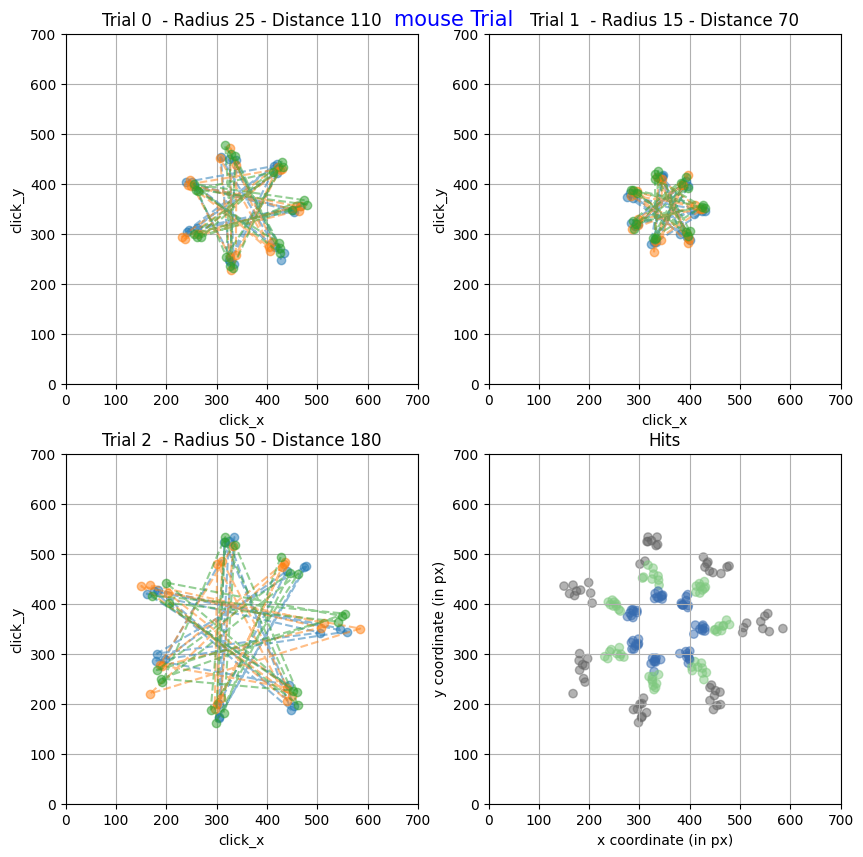

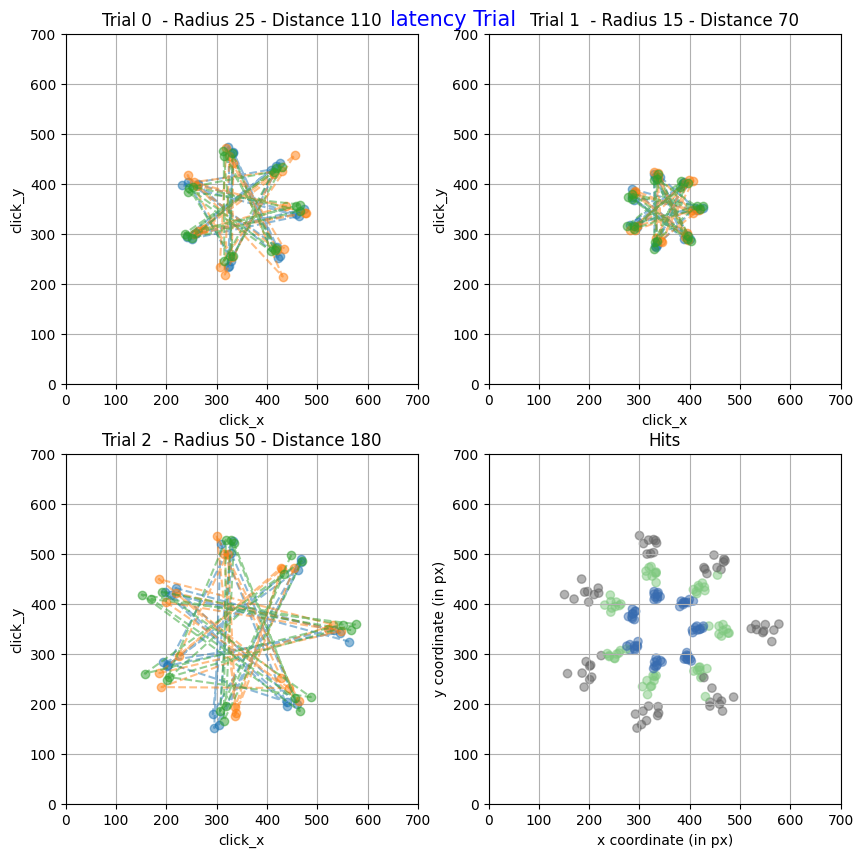

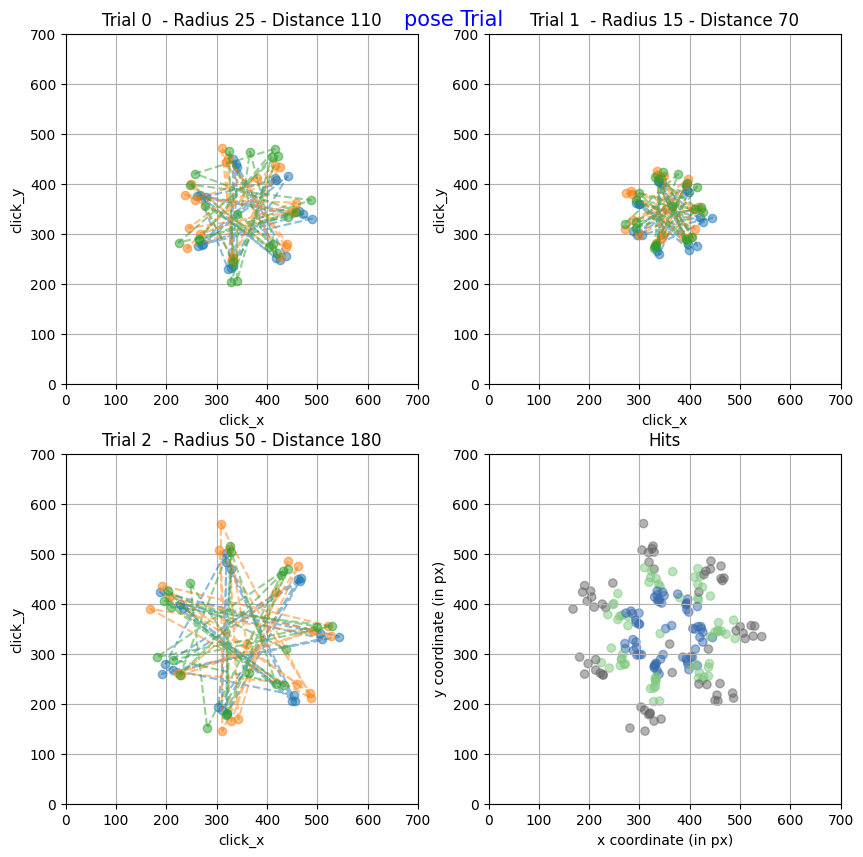

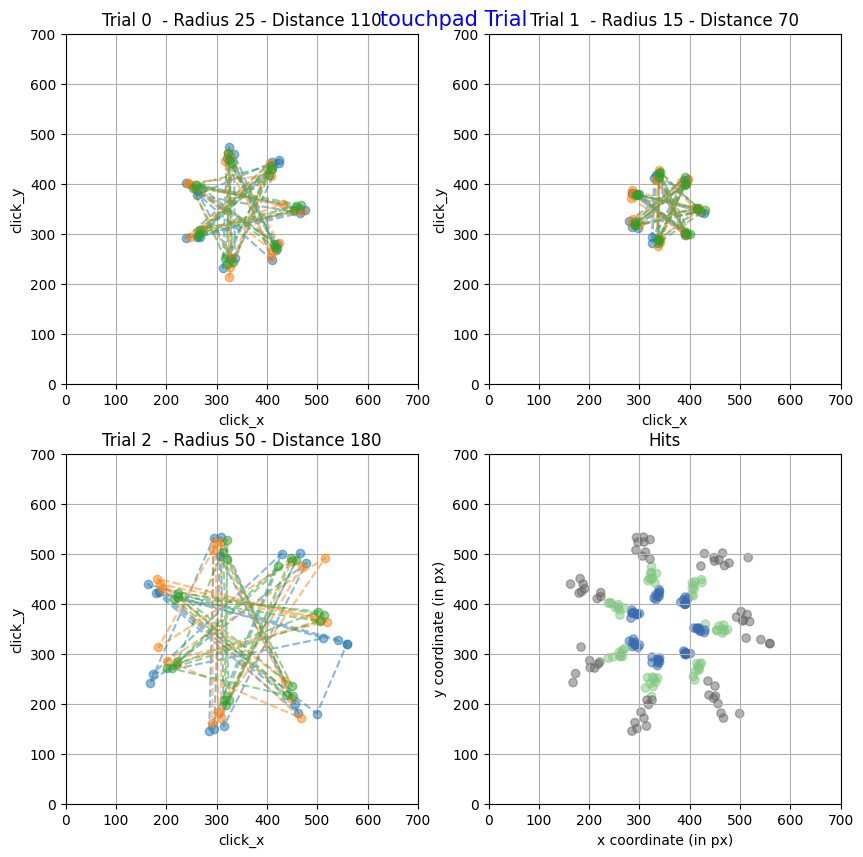

In [401]:
# access to data
devices = ["mouse", "latency", "pose", "touchpad"]
device_trials = {"mouse": mouse_trials, "latency": latency_trials, 
                 "pose": pose_trials, "touchpad": touchpad_trials}
device_dfs = {"mouse": df_mouse, "latency": df_latency, 
                 "pose": df_pose, "touchpad": df_touchpad}

# draw figur
for d in devices:
    plt.figure(figsize=(10, 10))
    plt.title(f"{d} Trial", fontsize=15, color="blue")
    plt.axis(False)

    trials = device_trials[d]

    for key, value in trials.items():
        # print(f'Participant {key} ----------')
        # v = number of trial 
        for v in value:
            plt.subplot(2, 2, v+1)
            plot_trial_path(trials[key][v])
        # break
    ax = plt.subplot(2, 2, 4)
    plot_all_hits(device_dfs[d])

    plt.show()

### Report

- the pose pointing device has the most misses by far ( 55 to 4 or 7)
- Chosen radii and distances had close ID
  - could have been Chosen a Little better to get more diverse data
  - bc small amount of data, creates more compareable data
- Movement time went up as ID did
  - mostly parallel: mouse/pose/latency very similar Steigung
  - touchpad ID's not as steep as the rest (start Little higher than mouse and then gets lower)
- avg. distance from target Center Pretty similar for mouse/latency/touchpad. For pose a lot higher
- time between clicks lowest for touchpad and mouse (no big difference), than latency and lastly pose with 1528ms

### Diskussion

- pose pointing not yet good enough to be a viable option for click input
  - highest error rate
  - highest MT/ID
- latency did not have a big impact on performance, just took longer to do
- mouse and touchpad had very similar performance, with the touchpad having a lower ID for higher MTs than mouse

---

### Problems
**Latency**
- first implementation used threaded delay
  - save mouse coordinates
  - wait the specified latency time 
  - move to the next coordinates faster than normal
  - basically delay than catch up
- FIX:
  - use threads to delay and save coordinates
  - cursor "wait" until delay is over
  - executes the mouse move event as they happend in real time

**Camera boundary pose pointing**
- had issues with reaching the edge of the screen, as detection ended, when finger was outside camera frame
- FIX:
  - add boundary to camera, so that the detection area is smaller than the camera frame
  - use indirect coordinates to translate between the frame and the screen
  
**Firing click events**
- fired mouse-click when fingers close enough together and mouse-release when they are far enough apart
- click-event fired constantly when fingers close together
- testing at that point was mostly done with pointing and dragging the camera window across the screen
- FIX:
  - add simple check
  - every click needs a release before a new one can fire

**Logging**
- not completely sure what data to log, so logged all data that we had access to
  - better to have more + unchanged data, than not
- Files would get overriden
  - good for debug, as it doesn't clutter the computer
  - bad for testing, if you forget to change the participants id or device in the config.csv
  - FIX: add checks at end of experiment
    - does log-folder exists (no: create)
    - does file exists, if yes ask wether to override/create a new (timestamped) file or don't save